## Описание проекта

In this competition your task will be to predict the probability for a tutor to be a proper one for preparing for the math exam. You will be given two datasets: train.csv (contains all features and the target) and test.csv (only features).

The evaluation metric is ROC AUC  

**Columns:** 
`Id`, `age`, `years_of_experience`, `lesson_price`, `qualification`, `physics`, `chemistry`, `biology`
`english`, `geography`, `history`, `mean_exam_points`,

**Target:**
`choose` 

## Подключение библиотек и загрузка данных

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn import over_sampling, under_sampling
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')
from matplotlib.colors import ListedColormap


color = {'orange': '#F46036', 'teal': '#0CA4A5', 'dblue': '#6D597A'}

In [6]:
def roc_auc(y_proba, y_true):
  '''
  Make a plot - ROC AUC curve, returns - area_under_curve value

  arguments:
  y_proba: numpy array - predicted probabilities 
  y_true: numpy array - true classes

  returns:
  area_under_curve: float
  '''

  TPR = []
  FPR = []
  tresholds = np.linspace(0, 1, 20)

  for treshold in tresholds:
    y_pred = np.where(y_proba >= treshold, 1, 0)

    TP = np.sum((y_true == y_pred) & (y_pred == 1))
    FP = np.sum((y_true != y_pred) & (y_pred == 1))
    TN = np.sum((y_true == y_pred) & (y_pred == 0))
    FN = np.sum((y_true != y_pred) & (y_pred == 0))
    
    tpr = TP / (TP + FN); TPR.append(tpr)
    fpr = FP / (FP + TN); FPR.append(fpr)

  area_under_curve = np.abs(np.trapz(TPR, FPR))
  x = np.linspace(0, 1, 50)
  y = x

  plt.figure(figsize=(10, 6))
  plt.plot(FPR, TPR, linewidth=1.5, color='#0B032D')
  plt.plot(x, y, linestyle='--', linewidth=1.5, color='#e36414')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC AUC curve', size=20)

  return f'ROC AUC score = {area_under_curve:.4f}'

In [7]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [8]:
df_train.sample(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
5862,5862,48.0,0.0,1150.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,63.0,1
2603,2603,56.0,2.0,1450.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0
6127,6127,56.0,1.0,1100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0
7407,7407,53.0,1.0,2200.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0
701,701,45.0,2.0,1300.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,63.0,0


In [9]:
df_test.sample(5)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
4321,14321,45.0,0.0,1450.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,59.0
9119,19119,47.0,2.0,1300.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,55.0
9672,19672,59.0,1.0,2200.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0
5574,15574,37.0,3.0,2300.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,89.0
6882,16882,68.0,2.0,2050.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,62.0


## EDA

Посмотрим на данные в датасете. Проверим, есть ли в данных пропуски и какого типа данные в каждой колонке 

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


Все данные числовые, пропуски отсутствуют и в trein и в test.  


**Обзор целевой переменной**

Посмотрим на значения целевой переменной.

In [12]:
df_train['choose'].value_counts(normalize=True)

0    0.8891
1    0.1109
Name: choose, dtype: float64

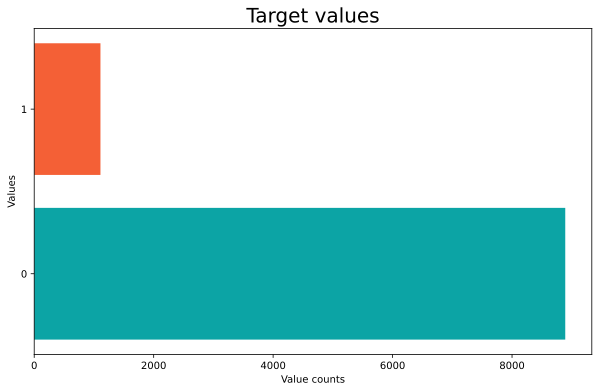

In [13]:
plt.figure(figsize=(10, 6))

x = np.arange(2)
target_count = df_train['choose'].value_counts()

plt.barh(x, target_count.values, color=[color['teal'], color['orange']])
plt.title('Target values', size=20)
plt.xlabel('Value counts')
plt.ylabel('Values')
plt.yticks(x, (0, 1))
plt.show()

Видно, что в целевой переменной наблюдается сильный дисбаланс классов

****Обзор признаков****

In [14]:
df_train.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


* `Id` - Колонка содержит ID преподавателя, информации для моделей в себе не несет.
* `age` - Среднее значение практически совпадает с медианой, минимальный и максимальный возраста совпадают с обычными для данной ситуации, значениями, скорее всего, выбросов в данных нет, значения соответствуют нормальному распределению.   
* `years_of_experience` - похожая ситуация с этой колонкой: cреднее значение практически совпадает с медианой, минимальный и максимальный опыт совпадают с обычными для данной ситуации, значениями, скорее всего, выбросов в данных нет.  
* `lesson_price` - есть небольшой сдвиг средней цены в сторону более высоких цен. Минимальное значение цены довольно назкое, возможно, есть выбросы.  
* `qualification` - категория преподавателя от 1 до 4  
* `physics`, `chemistry`, `biology`, `english`, `geography`, `history` - предмет, который преподаватель может вести дополнительно - бинарные признаки.
* `mean_exam_points` -  Средний балл практически совпадает с медианой, минимальное и максимальное значение совпадают с обычными для данной ситуации, значениями, скорее всего, выбросов в данных нет.  




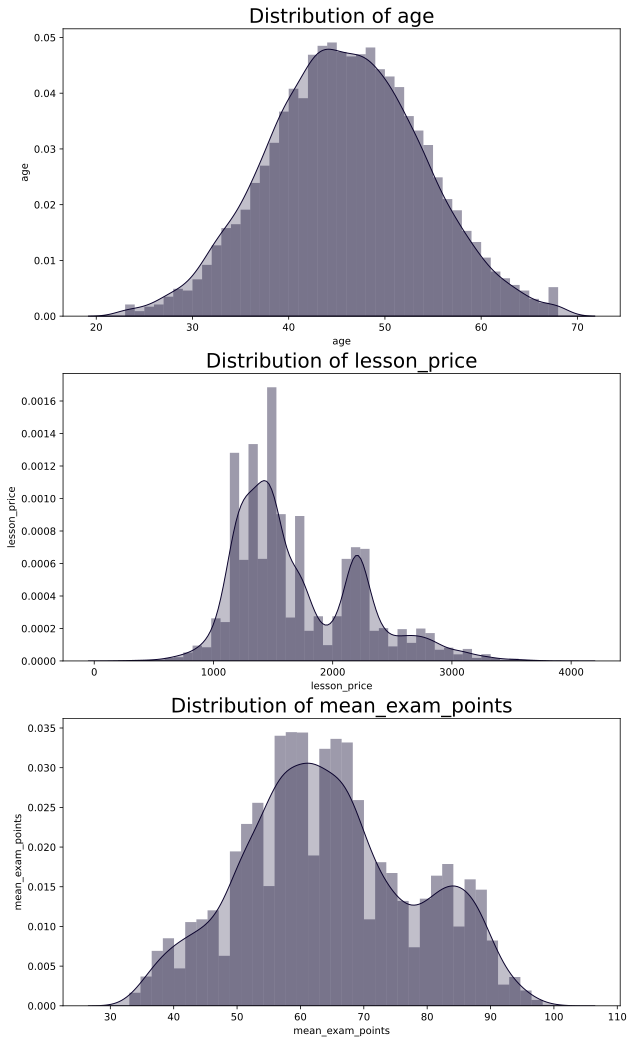

In [15]:
cols = ['age', 'lesson_price', 'mean_exam_points']

from scipy.stats import norm

fig=plt.figure(figsize=(10, 18))
y = np.linspace(0, 0.5, 10)

i=0
for column in cols:
    
    ax=plt.subplot(311+i)
    ax = plt.title(f"Distribution of {column}", size=20)
    ax = sns.distplot(df_train[column], kde_kws={"shade": True}, label='Life Ladder in 2020', color='#0B032D')
    ax = plt.ylabel(column)
    i+=1

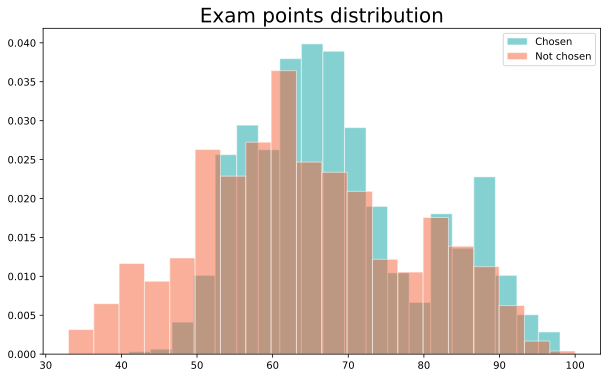

In [16]:
exam_chosen = df_train.loc[df_train['choose'] == 1, 'mean_exam_points']
exam_not_chosen = df_train.loc[df_train['choose'] == 0, 'mean_exam_points']

plt.figure(figsize = (10, 6))
plt.hist(exam_chosen, bins = 20, ec = 'White', color=color['teal'], alpha=0.5, density=True, label = 'Chosen')
plt.hist(exam_not_chosen, bins = 20, ec = 'White', color =color['orange'], alpha=0.5, density=True, label = 'Not chosen')
plt.title('Exam points distribution', size=20)
plt.legend()

plt.show()

In [17]:
cat_features = ['qualification', 'physics', 'chemistry', 'biology', 
                'english', 'geography', 'history']

for column in cat_features:
  print(f'\n{column}: \n{df_train[column].value_counts()}', '\n'+'-'*30)


qualification: 
1.0    4891
2.0    3033
3.0    2018
4.0      58
Name: qualification, dtype: int64 
------------------------------

physics: 
0.0    6294
1.0    3706
Name: physics, dtype: int64 
------------------------------

chemistry: 
0.0    8785
1.0    1215
Name: chemistry, dtype: int64 
------------------------------

biology: 
0.0    8828
1.0    1172
Name: biology, dtype: int64 
------------------------------

english: 
0.0    9409
1.0     591
Name: english, dtype: int64 
------------------------------

geography: 
0.0    9723
1.0     277
Name: geography, dtype: int64 
------------------------------

history: 
0.0    9820
1.0     180
Name: history, dtype: int64 
------------------------------


qualification - чем выше - тем меньше рекомендуют
physics, chemistry, biology, english, geography, history  - человек, который так же преподает физику более востребован для подготовки к экзамену по математике, чем преподающий химию, биологию, наименее востребованы преодаватели гуманитарных предметов.
 


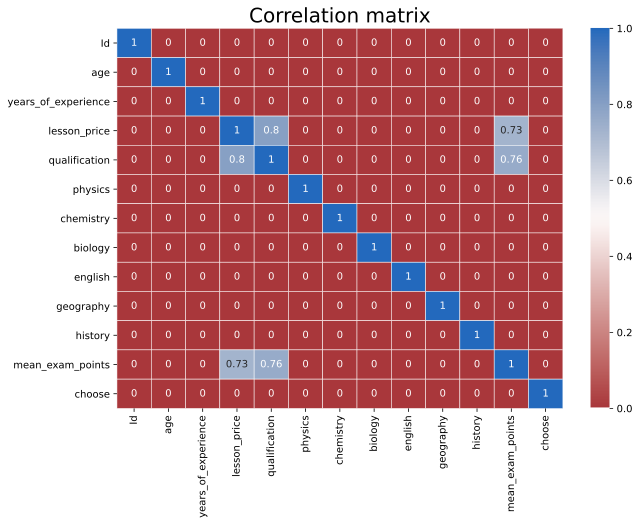

In [18]:
matrix = df_train.corr().round(decimals=2)
matrix[np.abs(matrix) < 0.3] = 0

plt.figure(figsize = (10, 7))
plt.title('Correlation matrix', size=20)
sns.heatmap(matrix, annot=True, vmax=True, linewidths=.5, cmap='vlag_r')
plt.plot()
plt.show()

Видно, средний балл зависит от квалификации преподавателя, а от этого зависит цена за урок. Зена за урок является одним из решающих факторов выбора преподавателя для подготовки к экзаменам

## Новые признаки

In [19]:
df_train['No_science'] = 0
df_test['No_science'] = 0

In [20]:
df_train['No_science'].loc[(df_train['chemistry'] == 1) | (df_train['biology'] == 1) | 
                          (df_train['english'] == 1) | (df_train['geography'] == 1) | 
                          (df_train['history'] == 1)] = 1

df_test['No_science'].loc[(df_test['chemistry'] == 1) | (df_test['biology'] == 1) | 
                          (df_test['english'] == 1) | (df_test['geography'] == 1) | 
                          (df_test['history'] == 1)] = 1

In [21]:
df_test['No_science'].value_counts()

0    6997
1    3003
Name: No_science, dtype: int64

In [22]:
columns = ['physics', 'chemistry', 'biology', 'english', 'geography', 'history']
df_train['knowledges'] = df_train[columns].sum(axis=1)
df_test['knowledges'] = df_test[columns].sum(axis=1)

In [23]:
# разносторонне развитый препод не всегда хорошо (чем больше предметов ведет, тем меньше его можно рекомендовать для сдачи экзамена по математике)

df_train.groupby('knowledges')['choose'].value_counts()

knowledges  choose
0.0         0         4174
            1          207
1.0         0         3670
            1          582
2.0         0          946
            1          270
3.0         0           97
            1           50
4.0         0            4
Name: choose, dtype: int64

In [46]:
# Разобьем признак на 10 групп
df_train['age_l'] = pd.cut(df_train['age'], 10, labels=False)
df_test['age_l'] = pd.cut(df_test['age'], 10, labels=False)
df_train['age_l'].value_counts()

5    2291
4    1919
3    1747
6    1410
7     935
2     753
1     380
8     309
9     153
0     103
Name: age_l, dtype: int64

In [25]:
df_train.loc[df_train['mean_exam_points'].between(50, 70)]

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose,No_science,knowledges,age_l
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1,1,3.0,6
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0,0,1.0,1
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1,0,0.0,2
5,5,37.0,3.0,1050.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0,0,0.0,3
6,6,54.0,3.0,800.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,52.0,1,1,1.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,9990,37.0,4.0,1600.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,67.0,0,1,2.0,3
9991,9991,45.0,5.0,1500.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,61.0,0,1,2.0,4
9994,9994,47.0,2.0,1550.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,62.0,0,1,1.0,5
9996,9996,53.0,2.0,1350.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0,0,0.0,6


In [26]:
df_train['exam_score'] = 1
df_train['exam_score'].loc[df_train['mean_exam_points'].between(50, 70)] = 2
df_train['exam_score'].loc[df_train['mean_exam_points'] > 75] = 3

df_test['exam_score'] = 1
df_test['exam_score'].loc[df_test['mean_exam_points'].between(50, 70)] = 2
df_test['exam_score'].loc[df_test['mean_exam_points'] > 75] = 3

In [27]:
df_train['price_lavel'] = 1
df_train['price_lavel'].loc[df_train['lesson_price'].between(1000, 2000)] = 2
df_train['price_lavel'].loc[df_train['lesson_price'].between(2000, 3000)] = 3
df_train['price_lavel'].loc[df_train['mean_exam_points'] > 3000] = 4

df_test['price_lavel'] = 1
df_test['price_lavel'].loc[df_test['lesson_price'].between(1000, 2000)] = 2
df_test['price_lavel'].loc[df_test['lesson_price'].between(2000, 3000)] = 3
df_test['price_lavel'].loc[df_test['lesson_price'] > 3000] = 4

In [28]:
pd.pivot_table(df_train, index='choose', columns='knowledges', aggfunc='count')

Id                       ... years_of_experience                  
knowledges     0.0     1.0    2.0   3.0  ...                 1.0    2.0   3.0  4.0
choose                                   ...                                      
0           4174.0  3670.0  946.0  97.0  ...              3670.0  946.0  97.0  4.0
1            207.0   582.0  270.0  50.0  ...               582.0  270.0  50.0  NaN

[2 rows x 80 columns]

In [29]:
pd.pivot_table(df_train, index='choose', columns='age', aggfunc='count')

Id                                ... years_of_experience                              
age    23.0 24.0 25.0 26.0 27.0 28.0 29.0  ...                62.0 63.0 64.0 65.0 66.0 67.0 68.0
choose                                     ...                                                  
0        20    8   15   20   32   45   41  ...                  58   54   40   27   21   12   34
1         1    1    2    1    3    4    5  ...                  10    2    6    4    3    2    4

[2 rows x 736 columns]

### Балансировка целевой переменной

In [30]:
# Сначала отбалансируем с помощью Tomek

from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_sample(df_train.drop(columns='choose'), df_train['choose'])
X_tomek = pd.DataFrame(data=X_tomek, columns=df_train.drop(columns='choose').columns)
y_tomek = pd.Series(y_tomek, name='choose')
df_bal = pd.concat([X_tomek, y_tomek], axis=1)
    
df_bal['choose'].value_counts()

0    8330
1    1109
Name: choose, dtype: int64

In [31]:
# Добавим еще наблюдений с помощью SMOTE

from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(df_bal.drop(columns='choose'), df_bal['choose'])
X_smote = pd.DataFrame(data=X_smote, columns=df_bal.drop(columns='choose').columns)
y_smote = pd.Series(y_smote, name='choose')
df_bal = pd.concat([X_smote, y_smote], axis=1)
    
df_bal['choose'].value_counts()

1    8330
0    8330
Name: choose, dtype: int64

In [32]:
df_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16660 entries, 0 to 16659
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   16660 non-null  float64
 1   age                  16660 non-null  float64
 2   years_of_experience  16660 non-null  float64
 3   lesson_price         16660 non-null  float64
 4   qualification        16660 non-null  float64
 5   physics              16660 non-null  float64
 6   chemistry            16660 non-null  float64
 7   biology              16660 non-null  float64
 8   english              16660 non-null  float64
 9   geography            16660 non-null  float64
 10  history              16660 non-null  float64
 11  mean_exam_points     16660 non-null  float64
 12  No_science           16660 non-null  float64
 13  knowledges           16660 non-null  float64
 14  age_l                16660 non-null  float64
 15  exam_score           16660 non-null 

### Масштабирование признаков

Так как далее будут использованы линейные и метрические алгоритмы, необходимо отмасштабировать данные. Для этого применим стандартизацию.

In [33]:
def standard_scale(X_train, X_test):
    """Стандартизация датасета целиком"""
    X_train_stand = X_train.copy()
    X_test_stand = X_test.copy()
    for i in range(X_train_stand.shape[1]):
        mean = X_train_stand.iloc[:, i].mean()
        std = X_train_stand.iloc[:, i].std()

        X_train_stand.iloc[:, i] = (X_train_stand.iloc[:, i] - mean) / std
        X_test_stand.iloc[:, i] = (X_test_stand.iloc[:, i] - mean) / std
    return X_train_stand, X_test_stand

In [34]:
df_train.columns

Index(['Id', 'age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points', 'choose', 'No_science', 'knowledges', 'age_l',
       'exam_score', 'price_lavel'],
      dtype='object')

In [35]:
cols_for_scale = ['age', 'years_of_experience', 'lesson_price', 'qualification', 
                  'mean_exam_points', 'No_science', 'knowledges', 'exam_score',
                  'price_lavel']
df_bal[cols_for_scale], df_test[cols_for_scale]= standard_scale(df_bal[cols_for_scale], df_test[cols_for_scale])

df_bal

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,No_science,knowledges,age_l,exam_score,price_lavel,choose
0,0.000000,-1.472115,-1.195428,1.028141,0.283716,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.598150,-0.802680,-1.245198,2.000000,-1.710525,1.529265,0
1,1.000000,0.804885,-0.008527,-0.733054,0.283716,1.000000,0.0,1.000000,0.000000,0.0,1.0,-0.735479,1.464367,2.911350,6.000000,-0.102493,-0.375116,1
2,2.000000,-2.275762,0.584923,0.245388,-0.957375,1.000000,0.0,0.000000,0.000000,0.0,0.0,-0.029440,-0.802680,0.140318,1.000000,-0.102493,-0.375116,0
3,3.000000,-1.739998,0.584923,-1.124431,-0.957375,0.000000,0.0,0.000000,0.000000,0.0,0.0,-0.029440,-0.802680,-1.245198,2.000000,-0.102493,-0.375116,1
4,6.000000,1.072768,0.584923,-1.613652,-0.957375,0.000000,1.0,0.000000,0.000000,0.0,0.0,-1.127723,1.464367,0.140318,6.000000,-0.102493,-2.279498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16655,7225.283353,-0.467270,-1.017140,-0.869952,-0.957375,0.300427,0.0,0.300427,0.000000,0.0,0.0,-0.554679,-0.121598,-0.412706,3.600854,-0.102493,-0.375116,1
16656,3402.640798,0.703777,-0.008527,0.465605,0.594851,0.749304,0.0,0.250696,0.000000,0.0,0.0,0.324343,-0.234342,0.140318,5.749304,0.300633,-0.375116,1
16657,9757.711685,2.257243,-0.237352,-0.909879,-0.957375,1.000000,0.0,0.000000,0.192792,0.0,0.0,-0.611657,-0.365611,0.407434,8.614416,-0.102493,-0.375116,1
16658,4318.610478,0.670944,1.484731,-0.255667,1.374706,0.120942,0.0,0.000000,0.000000,0.0,0.0,0.788604,-0.802680,-1.077631,6.000000,1.311059,-0.375116,1


### Разбивка датасета на обучающий и тестовый

In [36]:
X = df_bal.drop(columns=['Id', 'choose'])
y = df_bal['choose']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [37]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((11662, 16), (4998, 16), (11662,), (4998,))

### Логистическая регрессия

In [38]:
def calc_logloss(y, y_pred):
    pred_log = np.where(y_pred == 0, 1e-10, 0.9999999999) 
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

def eval_model(X, y, iterations, eta=1e-4, log=True):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    
    for i in range(iterations):
        z = np.dot(X, W)
        y_pred = 1 / (1 + np.exp(-z))
        err = calc_logloss(y, y_pred)
        
        dQ = 1/n * X.T @ (y_pred - y)
        W -= eta * dQ
        if i % (iterations / 10) == 0 and log==True:
            print(f'Iteration: {i}, Weights: {W}, Logloss: {err}')
    return W

def calc_pred_proba(X, W):
    z = np.dot(X, W)
    y_pred_proba = 1 / (1 + np.exp(-z))
    return y_pred_proba

In [39]:
X_train.columns

Index(['age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'chemistry', 'biology', 'english', 'geography', 'history',
       'mean_exam_points', 'No_science', 'knowledges', 'age_l', 'exam_score',
       'price_lavel'],
      dtype='object')

In [70]:
# model 1

cols = ['age', 'lesson_price', 'qualification', 
        # 'physics', 
        'chemistry', 
        'biology', 
        'english',
        'geography', 
        'history',
       'mean_exam_points', 
        # 'No_science', 
        'knowledges',
        # 'exam_score'
        ]

coef = eval_model(X_train[cols], y_train, 5000, eta=0.6)

Iteration: 0, Weights: age                 0.447209
lesson_price       -0.208937
qualification       0.641065
chemistry           1.505842
biology            -0.233809
english            -0.236642
geography           1.573841
history             0.763927
mean_exam_points   -0.419737
knowledges          0.557269
dtype: float64, Logloss: 0.7087761175782056
Iteration: 500, Weights: age                 0.045540
lesson_price       -3.375000
qualification       1.451409
chemistry          -0.098523
biology            -0.333037
english            -0.724749
geography           0.122717
history            -0.303418
mean_exam_points    1.861878
knowledges          0.739784
dtype: float64, Logloss: 0.4389596061952369
Iteration: 1000, Weights: age                 0.043559
lesson_price       -3.436356
qualification       1.488052
chemistry          -0.127799
biology            -0.352668
english            -0.813233
geography          -0.347452
history            -0.859155
mean_exam_points    1.8810

In [71]:
y_train_proba_1 = calc_pred_proba(X_train[cols], coef)
y_valid_proba_1 = calc_pred_proba(X_valid[cols], coef)

Train ROC AUC score: ROC AUC score = 0.8741
Valid ROC AUC score: ROC AUC score = 0.8769


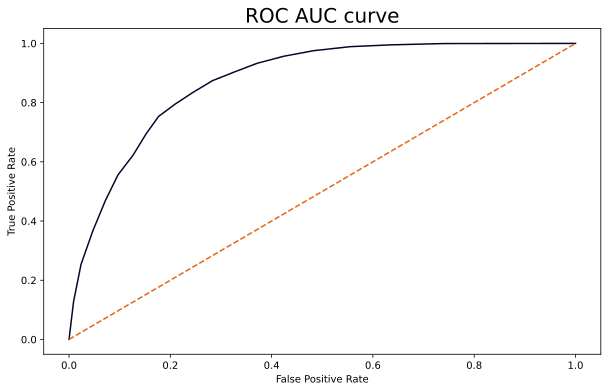

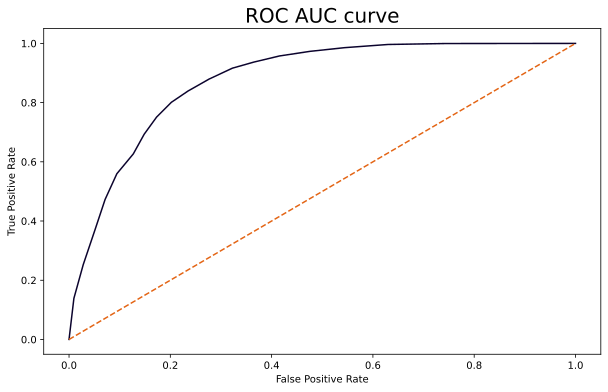

In [72]:
train_roc = roc_auc(y_train_proba_1, y_train)
valid_roc = roc_auc(y_valid_proba_1, y_valid)

print(f'Train ROC AUC score: {train_roc}',
      f'Valid ROC AUC score: {valid_roc}', sep='\n')

In [73]:
y_pred = calc_pred_proba(df_test[cols], coef)
y_pred = np.where(y_pred>0.78, 1, 0)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [74]:
project_pred = pd.DataFrame({'Id': df_test['Id'], 'choose': y_pred})
project_pred.to_csv('Sokolova_predictionsLog.csv', index=False, encoding='utf-8', sep=',')
project_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   choose  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [ ]:
stop

## KNN

In [ ]:
# model 2

def e_metrics(x1, x2):
    distance = np.sum(np.square(x1 - x2))
    return np.sqrt(distance)

def knn(x_train, y_train, x_test, k, weights=False, q=0.5):

    x_train = x_train.to_numpy()
    y_train  =y_train.to_numpy()
    x_test = x_test.to_numpy()

    probabilities = []
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответ на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов 
        for d in sorted(test_distances)[0:k]:

            if weights==True:
              # расчитаем вес объекта  
              weight = (q) ** d[0]
              classes[d[1]] += weight
            
            else:
              # подсчитаем частоту появления разных классов
              classes[d[1]] += 1


        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        probabilities.append(classes[1]/k)

    return answers, classes, probabilities

In [ ]:
y_pred_2, classes, proba_2 = knn(X_train, y_train, X_valid, 5, weights=True, q=0.5)

'ROC AUC score = 0.9398'

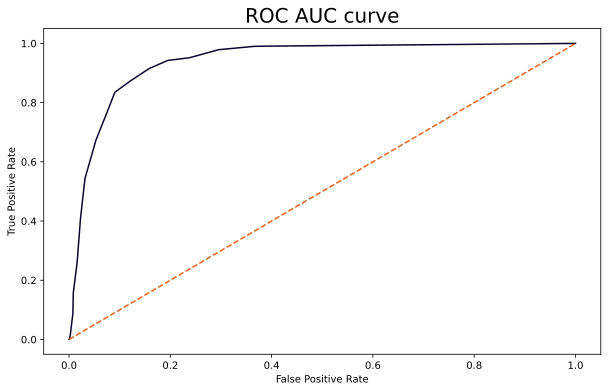

In [ ]:
knn_valid_roc = roc_auc(proba_2, y_valid)
knn_valid_roc

In [45]:
y_pred_f, classes, proba_2 = knn(df_train.drop(columns=['Id', 'choose']), df_train['choose'],
                                 df_test.drop(columns=['Id']), 5, weights=True, q=0.5)

In [46]:
project_pred_2 = pd.DataFrame({'Id': df_test['Id'], 'choose': y_pred_f})
project_pred_2.to_csv('Sokolova_predictions_KNN.csv', index=False, encoding='utf-8', sep=',')
project_pred_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   choose  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB
